<a href="https://colab.research.google.com/github/Sravya106/Cat-vs-Dog-Classification/blob/main/CatvsDog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Resizing, Rescaling, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.image import flip_up_down, flip_left_right
from tensorflow.keras.losses import BinaryCrossentropy

In [32]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2


# Fetching data from Kaggle


In [34]:
val_directroy = "/content/dataset/test"
train_directroy = "/content/dataset/train"
CLASS_NAMES = ["cats", "dogs"]

In [35]:
!pip install -q kaggle

In [36]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [37]:
!chmod 600 /root/.kaggle/kaggle.json

In [38]:
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

cats-and-dogs-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/cats-and-dogs-image-classification.zip" -d "/content/dataset"

In [40]:
train_data = image_dataset_from_directory(
    train_directroy,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 557 files belonging to 2 classes.


In [41]:
val_data = image_dataset_from_directory(
    val_directroy,
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 140 files belonging to 2 classes.


# Visualization if data

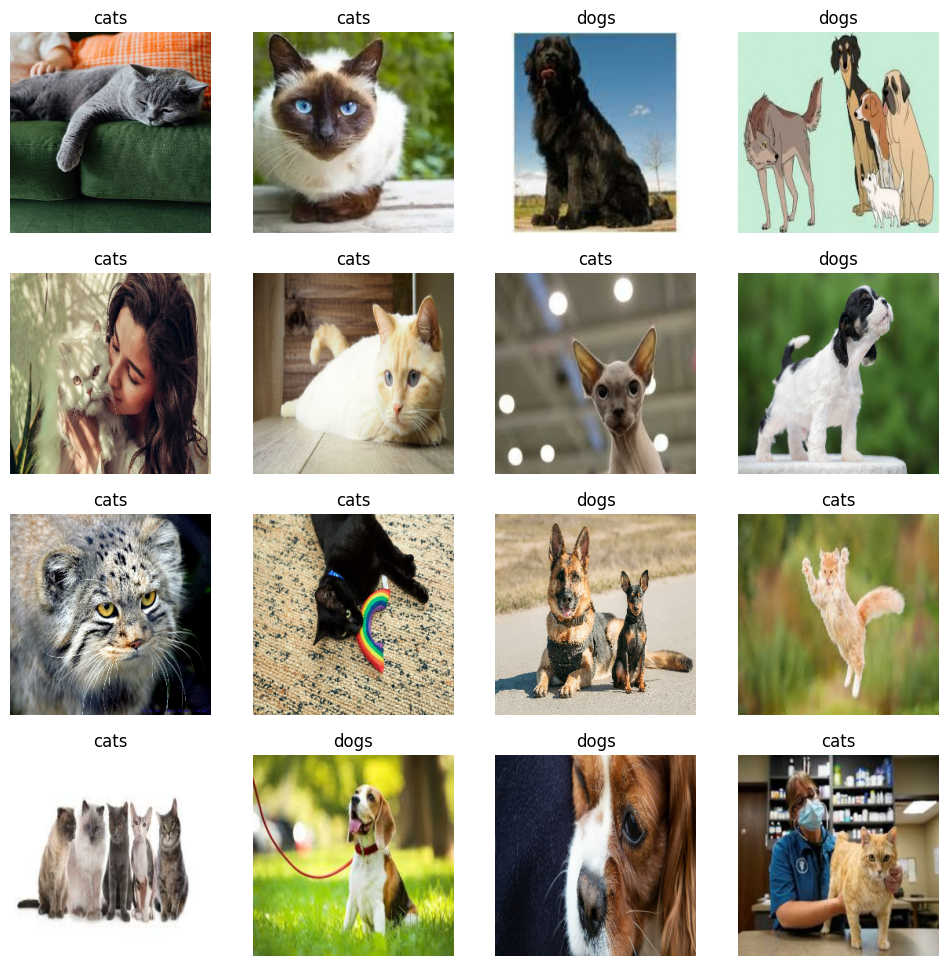

In [42]:
plt.figure(figsize=(12, 12))

for images, labels in val_data.take(1):
    for i in range(16):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i] / 255)
      plt.title(CLASS_NAMES[labels[i]])
      plt.axis("off")

plt.show()

In [43]:
num_cats = 0
num_dogs = 0


for images, labels in train_data:
    labels = labels.numpy()

    num_cats += sum(labels == 0)
    num_dogs += sum(labels == 1)


print(f"Number of cat images: {num_cats}")
print(f"Number of dog images: {num_dogs}")

Number of cat images: 279
Number of dog images: 278


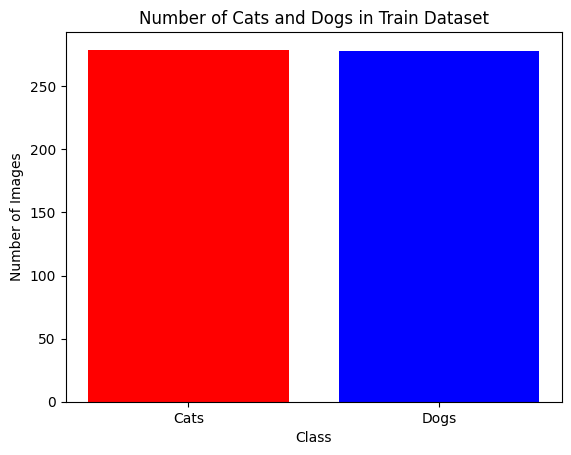

In [44]:
classes = ['Cats', 'Dogs']
counts = [num_cats, num_dogs]

plt.bar(classes, counts, color = ['red', 'blue'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Cats and Dogs in Train Dataset')
plt.show()

# Data Preparation

In [45]:
train_data = (train_data.prefetch(tf.data.AUTOTUNE))

In [46]:
val_data = (val_data.prefetch(tf.data.AUTOTUNE))

In [47]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
])

# Model building
Vgg16 is a pre-trained model contining 16 layers. Transfe learning is the method used to build this model making use of Vgg16 model. This enables us to increase the accuract of the model with minimun computational time and power.

---

**VGG16 architecture**: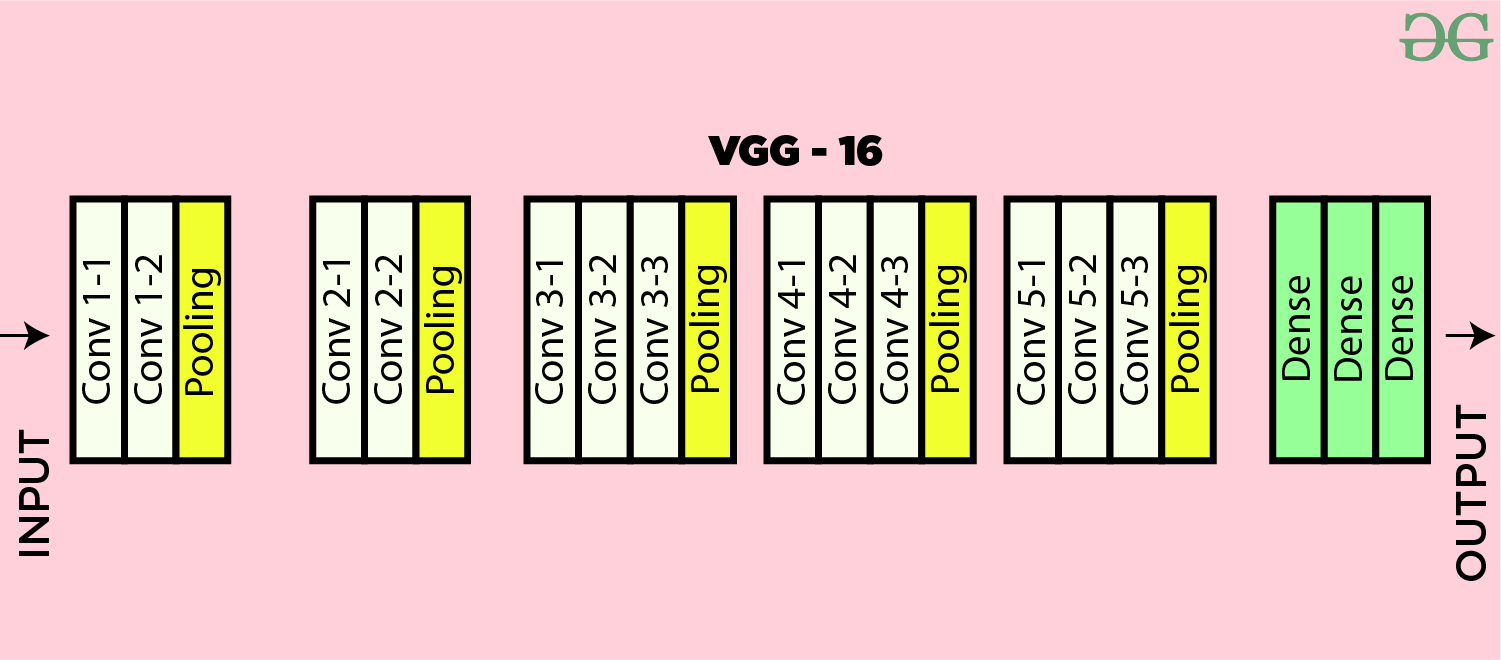




In [48]:
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [49]:
base_model.trainable = False

model = models.Sequential([
    resize_rescale_layers,
    base_model,
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(3),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.1)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


# Training


In [50]:
loss_function = BinaryCrossentropy()

In [51]:
def learning_rate_scheduler(epoch, lr):
  if epoch < 4:
    return lr
  else:
    return lr*0.9

In [52]:
lr_scheduler = LearningRateScheduler(lambda epoch, lr: learning_rate_scheduler(epoch, lr))

In [53]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

In [54]:
model.compile(optimizer= 'adam', loss=loss_function, metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks = [lr_scheduler, early_stopping])

Epoch 1/10
18/18 [==============================] - 359s 20s/step - loss: 3.2350 - accuracy: 0.6014 - val_loss: 2.6927 - val_accuracy: 0.7357 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - 357s 20s/step - loss: 2.2679 - accuracy: 0.7917 - val_loss: 1.8726 - val_accuracy: 0.8143 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - 354s 20s/step - loss: 1.5191 - accuracy: 0.8743 - val_loss: 1.3758 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 1.0335 - accuracy: 0.9390 

# Model Evaluation

In [56]:
evaluation_result = model.evaluate(val_data)
print("Evaluation Result:", evaluation_result)

5/5 [==============================] - 69s 13s/step - loss: 1.8726 - accuracy: 0.8143
Evaluation Result: [1.8725980520248413, 0.8142856955528259]


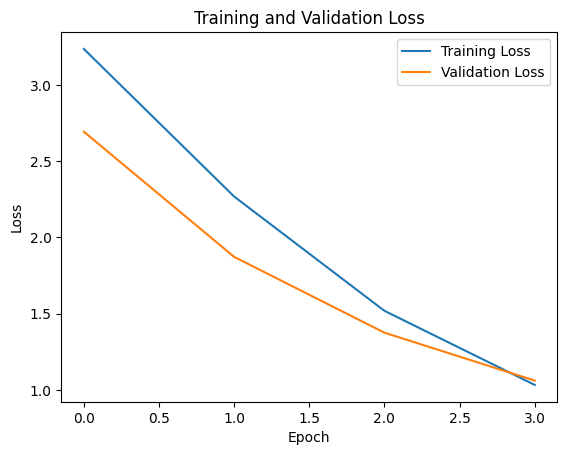

In [57]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

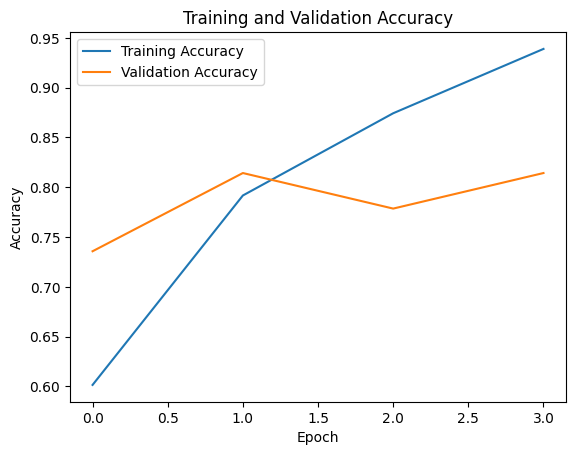

In [58]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()